#**1. Contexto e Hipótese Principal**
Objetivo geral: Responder a pergunta "A probabilidade de um hospital possuir uma UTI especializada em Queimados é significativamente maior em BA, MT e TO (devido ao histórico de queimadas) do que em SP?"

Hipóteses estatísticas:

- H₀: Estados com maior incidência de queimadas possuem melhor infraestrutura de UTIs especializadas.
- H₁: O estado de São Paulo possui mais UTIs especializadas.

In [2]:
#@title **Montar Google Drive e dar permissão** { vertical-output: true, form-width: "30%" }
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
#@title **Importar bibliotecas** { vertical-output: true, form-width: "60%" }
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
from IPython.display import display
import scipy.stats as sp_stats

In [ ]:
#@title **Configuração de estilo** { vertical-output: true, form-width: "60%" }
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

In [30]:
#@title **Preparação dos Dados**
# --- 1. Carregamento e Tratamento de Dados ---
def normalize_text(text):
    if pd.isna(text): return text
    if isinstance(text, str):
        return ''.join(c for c in unicodedata.normalize('NFD', text)
                  if unicodedata.category(c) != 'Mn').upper()
    return text

# Carregar dados separadamente para análise temporal
try:
    df_2023 = pd.read_csv('/content/drive/MyDrive/Leitos_2023.csv', encoding='utf-8', sep=',', quotechar='"', on_bad_lines='skip', low_memory=False)
    df_2024 = pd.read_csv('/content/drive/MyDrive/Leitos_2024.csv', encoding='utf-8', sep=',', quotechar='"', on_bad_lines='skip', low_memory=False)
except:
    df_2023 = pd.read_csv('/content/drive/MyDrive/Leitos_2023.csv', encoding='latin1', sep=',', quotechar='"', on_bad_lines='skip', low_memory=False)
    df_2024 = pd.read_csv('/content/drive/MyDrive/Leitos_2024.csv', encoding='latin1', sep=',', quotechar='"', on_bad_lines='skip', low_memory=False)

# Adicionar coluna de ano
df_2023['ANO'] = 2023
df_2024['ANO'] = 2024

# Função para processar cada dataframe
def process_dataframe(df, year):
    target_states = ['SP', 'BA', 'MT', 'TO']
    df = df[df['UF'].isin(target_states)].copy()

    df['GROUP'] = df['UF'].apply(lambda x: 'High_Risk' if x in ['BA', 'MT', 'TO'] else 'SP')
    df['UTI_QUEIMADO_EXIST'] = df['UTI_QUEIMADO_EXIST'].fillna(0)
    df['HAS_BURN_ICU'] = (df['UTI_QUEIMADO_EXIST'] > 0).astype(int)

    df['MUNICIPIO_NORM'] = df['MUNICIPIO'].apply(normalize_text)
    capitals = ['SAO PAULO', 'SALVADOR', 'CUIABA', 'PALMAS']
    df['IS_CAPITAL'] = df['MUNICIPIO_NORM'].isin(capitals)

    df_unique = df.groupby('CNES').agg({
        'UF': 'first',
        'GROUP': 'first',
        'MUNICIPIO': 'first',
        'IS_CAPITAL': 'first',
        'UTI_QUEIMADO_EXIST': 'max',
        'HAS_BURN_ICU': 'max',
        'ANO': 'first'
    }).reset_index()

    return df_unique

# Processar cada ano separadamente
df_2023_unique = process_dataframe(df_2023, 2023)
df_2024_unique = process_dataframe(df_2024, 2024)

# 2. Combinar os resultados
df_unique = pd.concat([df_2023_unique, df_2024_unique], ignore_index=True)


In [31]:
#@title **Resumo dos dados** { vertical-output: true, form-width: "60%" }

print("="*80)
print("Resumo dos dados")
print("="*80)
print(f"Total de registros 2023: {len(df_2023):,}")
print(f"Total de registros 2024: {len(df_2024):,}")
print(f"Hospitais únicos 2023: {len(df_2023_unique):,}")
print(f"Hospitais únicos 2024: {len(df_2024_unique):,}")
print(f"Hospitais únicos (geral): {len(df_unique):,}")

Resumo dos dados
Total de registros 2023: 84,471
Total de registros 2024: 85,225
Hospitais únicos 2023: 1,934
Hospitais únicos 2024: 1,938
Hospitais únicos (geral): 3,872


In [36]:
#@title **Análise comparativa de 2023 com 2024** { vertical-output: true, form-width: "60%" }

# --- ANÁLISE TEMPORAL (2023 vs 2024) ---
print("\n" + "="*80)
print("ANÁLISE TEMPORAL: 2023 vs 2024")
print("="*80)

def compare_years(df_2023, df_2024):
    """Compara os dados entre 2023 e 2024"""

    comparison = pd.DataFrame({
        'Métrica': ['Total Hospitais', 'Hospitais com UTI', 'Proporção (%)',
                   'Total Leitos', 'Média Leitos/Hospital'],
        '2023': [
            len(df_2023),
            df_2023['HAS_BURN_ICU'].sum(),
            (df_2023['HAS_BURN_ICU'].mean() * 100),
            df_2023['UTI_QUEIMADO_EXIST'].sum(),
            df_2023['UTI_QUEIMADO_EXIST'].mean()
        ],
        '2024': [
            len(df_2024),
            df_2024['HAS_BURN_ICU'].sum(),
            (df_2024['HAS_BURN_ICU'].mean() * 100),
            df_2024['UTI_QUEIMADO_EXIST'].sum(),
            df_2024['UTI_QUEIMADO_EXIST'].mean()
        ]
    })

    comparison['Variação (%)'] = ((comparison['2024'] - comparison['2023']) /
                                   comparison['2023'] * 100).round(2)

    return comparison

# Comparação Geral
print("\n--- Comparação Geral 2023 vs 2024 ---")
comp_geral = compare_years(df_2023_unique, df_2024_unique)
display(comp_geral.style.format(precision=1, decimal=',', thousands='.'))
# print(comp_geral.to_string(index=False))

# Comparação por Grupo
print("\n--- Comparação por Grupo ---")
for group in ['SP', 'High_Risk']:
    print(f"\n{group}:")
    df_23_g = df_2023_unique[df_2023_unique['GROUP'] == group]
    df_24_g = df_2024_unique[df_2024_unique['GROUP'] == group]
    comp_group = compare_years(df_23_g, df_24_g)
    display(comp_group.style.format(precision=1, decimal=',', thousands='.'))
    # print(comp_group.to_string(index=False))

# Teste estatístico para mudança temporal
print("\n--- Teste de Mudança Temporal (Qui-Quadrado) ---")
# Criar tabela de contingência: Ano vs Presença de UTI
temporal_cont = pd.DataFrame({
    '2023': [df_2023_unique['HAS_BURN_ICU'].sum(),
             len(df_2023_unique) - df_2023_unique['HAS_BURN_ICU'].sum()],
    '2024': [df_2024_unique['HAS_BURN_ICU'].sum(),
             len(df_2024_unique) - df_2024_unique['HAS_BURN_ICU'].sum()]
}, index=['Com UTI', 'Sem UTI'])

chi2_temp, p_temp, _, _ = stats.chi2_contingency(temporal_cont.T)
print(f"χ² = {chi2_temp:.4f}, P-valor = {p_temp:.6f}")
print(f"\nObjetivo dessa análise: verificar se houve mudança significativa para a presença de UTIs nos estados analisados entre 2023 e 2024")
print(f"Conclusão: Sem mudança significativa")



ANÁLISE TEMPORAL: 2023 vs 2024

--- Comparação Geral 2023 vs 2024 ---


,Métrica,2023,2024,Variação (%)
0,Total Hospitais,"1.934,0","1.938,0","0,2"
1,Hospitais com UTI,"25,0","25,0","0,0"
2,Proporção (%),"1,3","1,3","-0,2"
3,Total Leitos,"110,0","111,0","0,9"
4,Média Leitos/Hospital,"0,1","0,1","0,7"



--- Comparação por Grupo ---

SP:


,Métrica,2023,2024,Variação (%)
0,Total Hospitais,"1.026,0","1.035,0","0,9"
1,Hospitais com UTI,"20,0","20,0","0,0"
2,Proporção (%),"1,9","1,9","-0,9"
3,Total Leitos,"87,0","87,0","0,0"
4,Média Leitos/Hospital,"0,1","0,1","-0,9"



High_Risk:


,Métrica,2023,2024,Variação (%)
0,Total Hospitais,"908,0","903,0","-0,6"
1,Hospitais com UTI,"5,0","5,0","0,0"
2,Proporção (%),"0,6","0,6","0,6"
3,Total Leitos,"23,0","24,0","4,3"
4,Média Leitos/Hospital,"0,0","0,0","4,9"



--- Teste de Mudança Temporal (Qui-Quadrado) ---
χ² = 0.0000, P-valor = 1.000000

Objetivo dessa análise: verificar se houve mudança significativa para a presença de UTIs nos estados analisados entre 2023 e 2024
Conclusão: Sem mudança significativa


In [51]:
#@title **Análise descritiva geral** { vertical-output: true, form-width: "60%" }

# --- 3. ESTATÍSTICA DESCRITIVA ---
print("\n" + "="*80)
print("ESTATÍSTICA DESCRITIVA DETALHADA")
print("="*80)

def get_comprehensive_stats(df, col, group):
    """Estatísticas descritivas completas"""
    stats_dict = {}

    for g in df[group].unique():
        data = df[df[group] == g][col]
        stats_dict[g] = {
            'N': len(data),
            'N com UTI': (data > 0).sum(),
            'Proporção (%)': ((data > 0).sum() / len(data) * 100),
            'Média': data.mean(),
            'Mediana': data.median(),
            'DP': data.std(),
            'Min': data.min(),
            'Max': data.max(),
            'Q1': data.quantile(0.25),
            'Q3': data.quantile(0.75),
            'CV (%)': (data.std() / data.mean() * 100) if data.mean() > 0 else 0,
            'Assimetria': sp_stats.skew(data),
            'Curtose': sp_stats.kurtosis(data)
        }

    return pd.DataFrame(stats_dict).T

stats_comprehensive = get_comprehensive_stats(df_unique, 'UTI_QUEIMADO_EXIST', 'GROUP')
# print(stats_comprehensive.round(3))

# Para que serve assimetria e curtose?
# Medir a forma de distribuição dos dados
# Ou provar matematicamente que os dados não seguem a forma normal
# Assimetria: Indica onde estão os valores extremos (outliers).

# Curtose: Indica o quão concentrados os dados estão em torno da moda
# e o quão "pesadas" são os outliers.

display(stats_comprehensive.style.format({
    'N': '{:.0f}',
    'N com UTI': '{:.0f}',
    'Proporção (%)': '{:.2f}%',
    'Média': '{:.3f}',
    'Mediana': '{:.1f}',
    'DP': '{:.3f}',
    'CV (%)': '{:.1f}%',
    'Assimetria': '{:.2f}',
    'Curtose': '{:.2f}'
}, decimal=',', thousands='.'))


ESTATÍSTICA DESCRITIVA DETALHADA


,N,N com UTI,Proporção (%),Média,Mediana,DP,Min,Max,Q1,Q3,CV (%),Assimetria,Curtose
High_Risk,1811,10,"0,55%","0,026","0,0","0,367","0,000000","6,000000","0,000000","0,000000","1414,1%","14,87","225,85"
SP,2061,40,"1,94%","0,084","0,0","0,728","0,000000","12,000000","0,000000","0,000000","862,1%","11,08","142,71"


In [60]:
#@title **Análise da probabilidade de ter um hospital com UTI especializada** { vertical-output: true, form-width: "60%" }
# --- ANÁLISE DE PROBABILIDADE ---

# Probabilidade Condicional: P(Tem UTI | Estado)
# P(A|B) = Probabilidade de ter UTI dado que está no Grupo X

def calc_probabilidade(df, group_name):
    total = len(df[df['GROUP'] == group_name])
    if total == 0:
        return 0, 0, 0
    com_uti = len(df[(df['GROUP'] == group_name) & (df['HAS_BURN_ICU'] == 1)])
    prob = com_uti / total
    return prob, com_uti, total

prob_sp, n_uti_sp, total_sp = calc_probabilidade(df_unique, 'SP')
prob_hr, n_uti_hr, total_hr = calc_probabilidade(df_unique, 'High_Risk')

print(f"Probabilidade:")
print(f"1. P(Ter UTI | Estar em SP) = {prob_sp:.4f} ({prob_sp*100:.2f}%)")
print(f"2. P(Ter UTI | Estar em High Risk) = {prob_hr:.4f} ({prob_hr*100:.2f}%)")

# Razão de Chances
# Quantas vezes é mais provável encontrar UTI em SP do que no High Risk?
razao = prob_sp / prob_hr
print(f"\nINTERPRETAÇÃO DE PROBABILIDADE:")
print(f"Um paciente em um hospital aleatório de SP tem {razao:.1f} vezes mais chance de encontrar uma UTI especializada do que na região de Alto Risco.")

Probabilidade:
1. P(Ter UTI | Estar em SP) = 0.0194 (1.94%)
2. P(Ter UTI | Estar em High Risk) = 0.0055 (0.55%)

INTERPRETAÇÃO DE PROBABILIDADE:
Um paciente em um hospital aleatório de SP tem 3.5 vezes mais chance de encontrar uma UTI especializada do que na região de Alto Risco.



TESTES DE NORMALIDADE

Shapiro-Wilk Test:
SP: statistic=0.094674, p-valor=0.000000 (Não-Normal)
High Risk: statistic=0.043050, p-valor=0.000000 (Não-Normal)

Levene Test (Homogeneidade de Variâncias):
statistic=9.553557, p-valor=0.002010 (Variâncias diferentes)


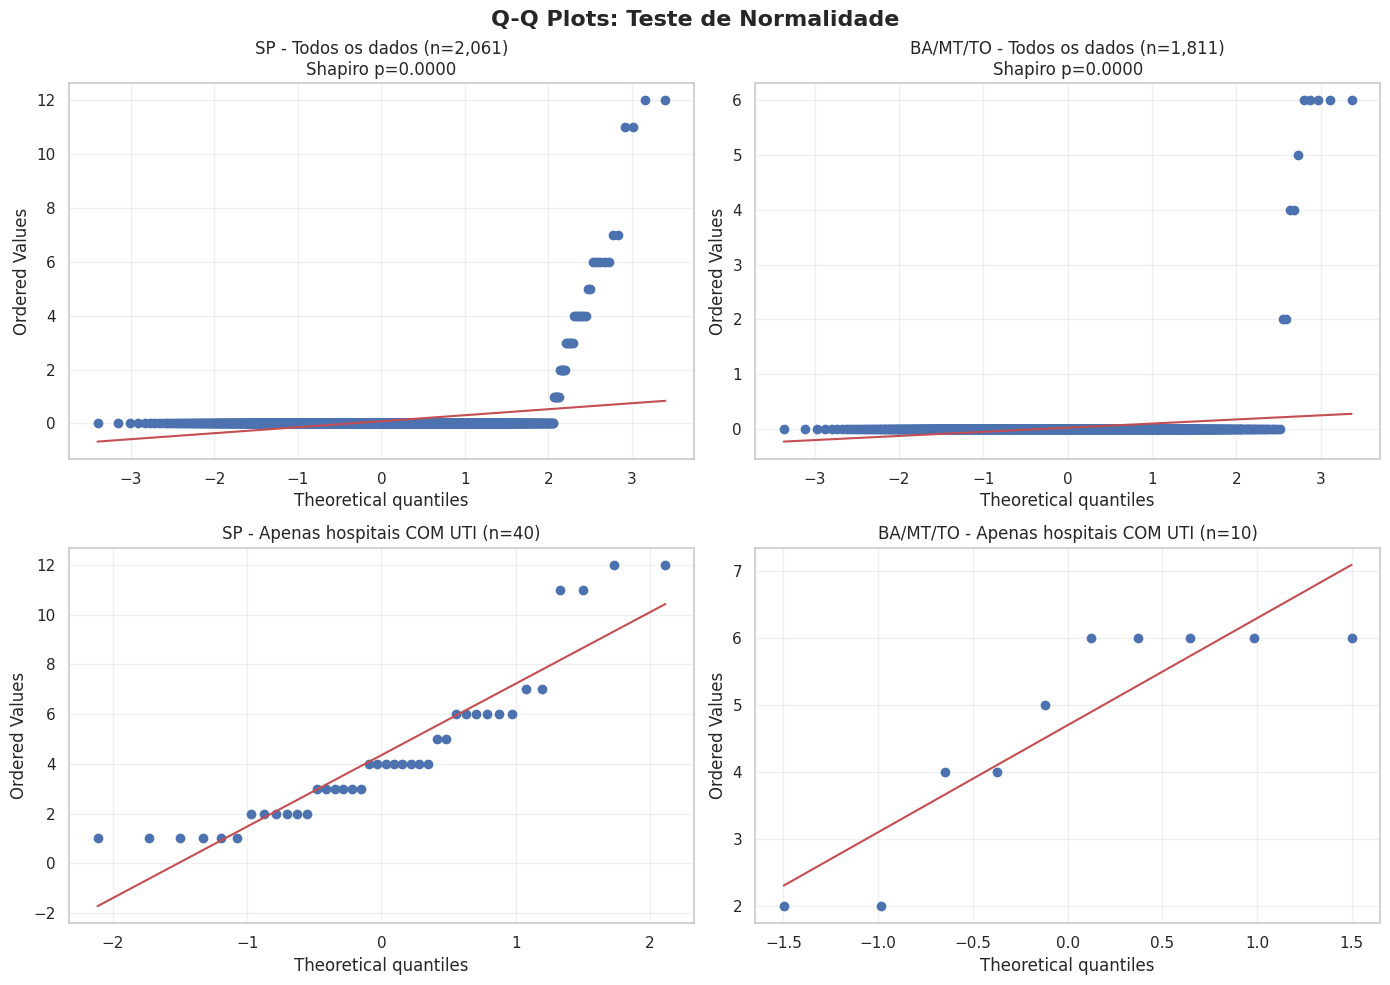

In [69]:
#@title **Testes de normalidade** { vertical-output: true, form-width: "60%" }

# --- TESTES DE NORMALIDADE ---
print("\n" + "="*80)
print("TESTES DE NORMALIDADE")
print("="*80)

sp_data = df_unique[df_unique['GROUP']=='SP']['UTI_QUEIMADO_EXIST']
hr_data = df_unique[df_unique['GROUP']=='High_Risk']['UTI_QUEIMADO_EXIST']

# Teste de Shapiro-Wilk
# Validação para que seja utilizado uma amostra caso sejam muitos dados
if len(sp_data) > 5000:
    sp_sample = sp_data.sample(5000, random_state=42)
    hr_sample = hr_data.sample(5000, random_state=42)
else:
    sp_sample = sp_data
    hr_sample = hr_data

stat_sp, p_sp = stats.shapiro(sp_sample)
stat_hr, p_hr = stats.shapiro(hr_sample)

print(f"\nShapiro-Wilk Test:")
print(f"SP: statistic={stat_sp:.6f}, p-valor={p_sp:.6f} (Não-Normal)")
print(f"High Risk: statistic={stat_hr:.6f}, p-valor={p_hr:.6f} (Não-Normal)")

# Teste de Levene (homogeneidade de variâncias)
stat_lev, p_lev = stats.levene(sp_data, hr_data)
print(f"\nLevene Test (Homogeneidade de Variâncias):")
print(f"statistic={stat_lev:.6f}, p-valor={p_lev:.6f} {'(Variâncias iguais)' if p_lev > 0.05 else '(Variâncias diferentes)'}")

# QQ-Plots para visualização da normalidade
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Q-Q Plots: Teste de Normalidade', fontsize=16, fontweight='bold')

# SP - Todos os dados
sp_stats.probplot(sp_data, dist="norm", plot=axes[0, 0])
axes[0, 0].set_title(f'SP - Todos os dados (n={len(sp_data):,})\nShapiro p={p_sp:.4f}')
axes[0, 0].grid(True, alpha=0.3)

# High Risk - Todos os dados
sp_stats.probplot(hr_data, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title(f'BA/MT/TO - Todos os dados (n={len(hr_data):,})\nShapiro p={p_hr:.4f}')
axes[0, 1].grid(True, alpha=0.3)

# SP - Apenas hospitais COM UTI
sp_with_icu = sp_data[sp_data > 0]
sp_stats.probplot(sp_with_icu, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title(f'SP - Apenas hospitais COM UTI (n={len(sp_with_icu):,})')
axes[1, 0].grid(True, alpha=0.3)

# High Risk - Apenas hospitais COM UTI
hr_with_icu = hr_data[hr_data > 0]
sp_stats.probplot(hr_with_icu, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title(f'BA/MT/TO - Apenas hospitais COM UTI (n={len(hr_with_icu):,})')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

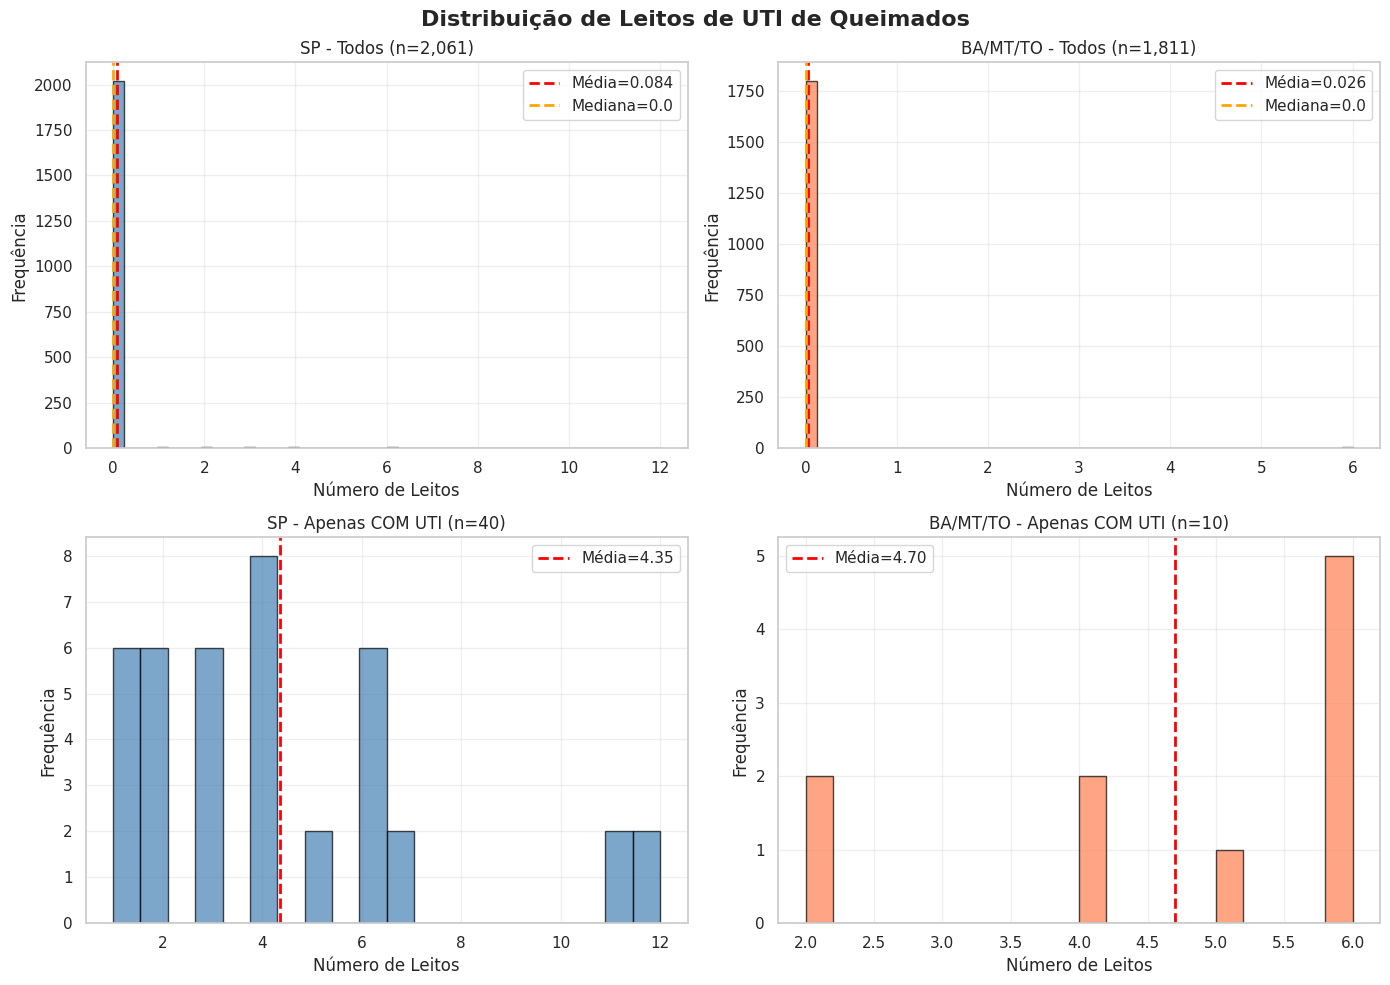

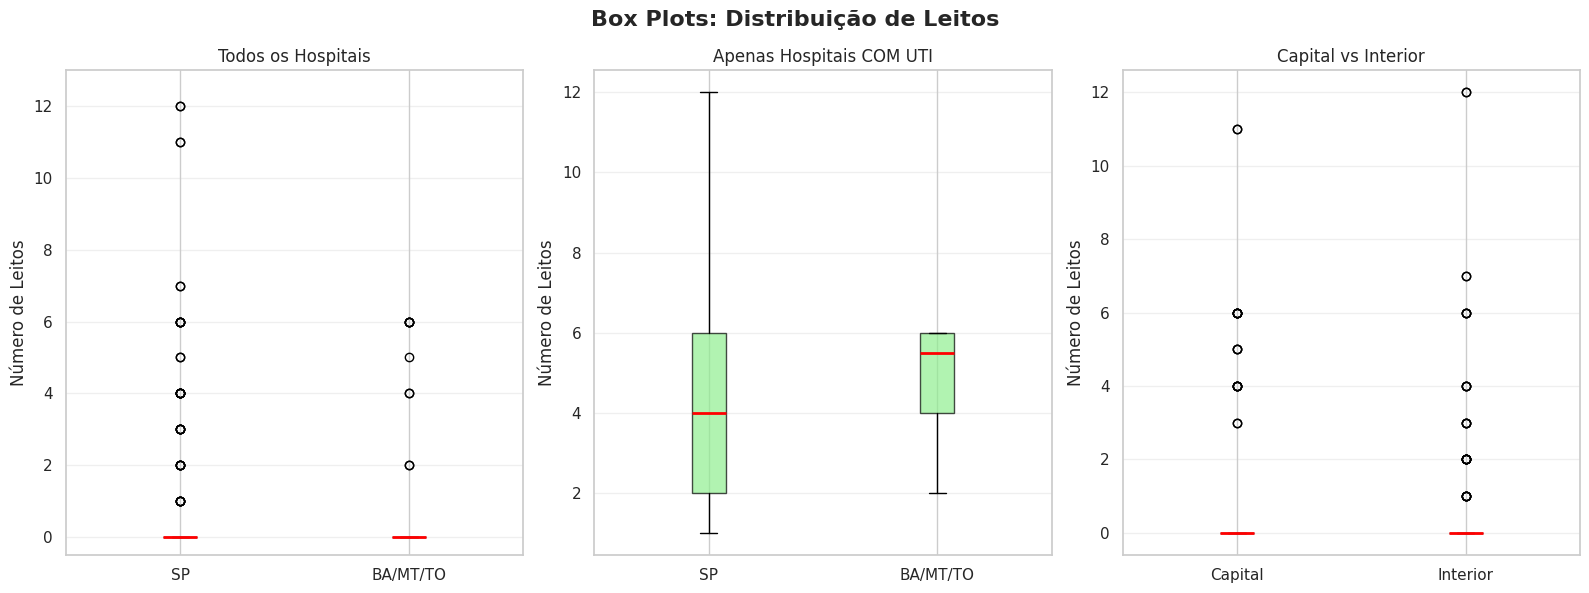

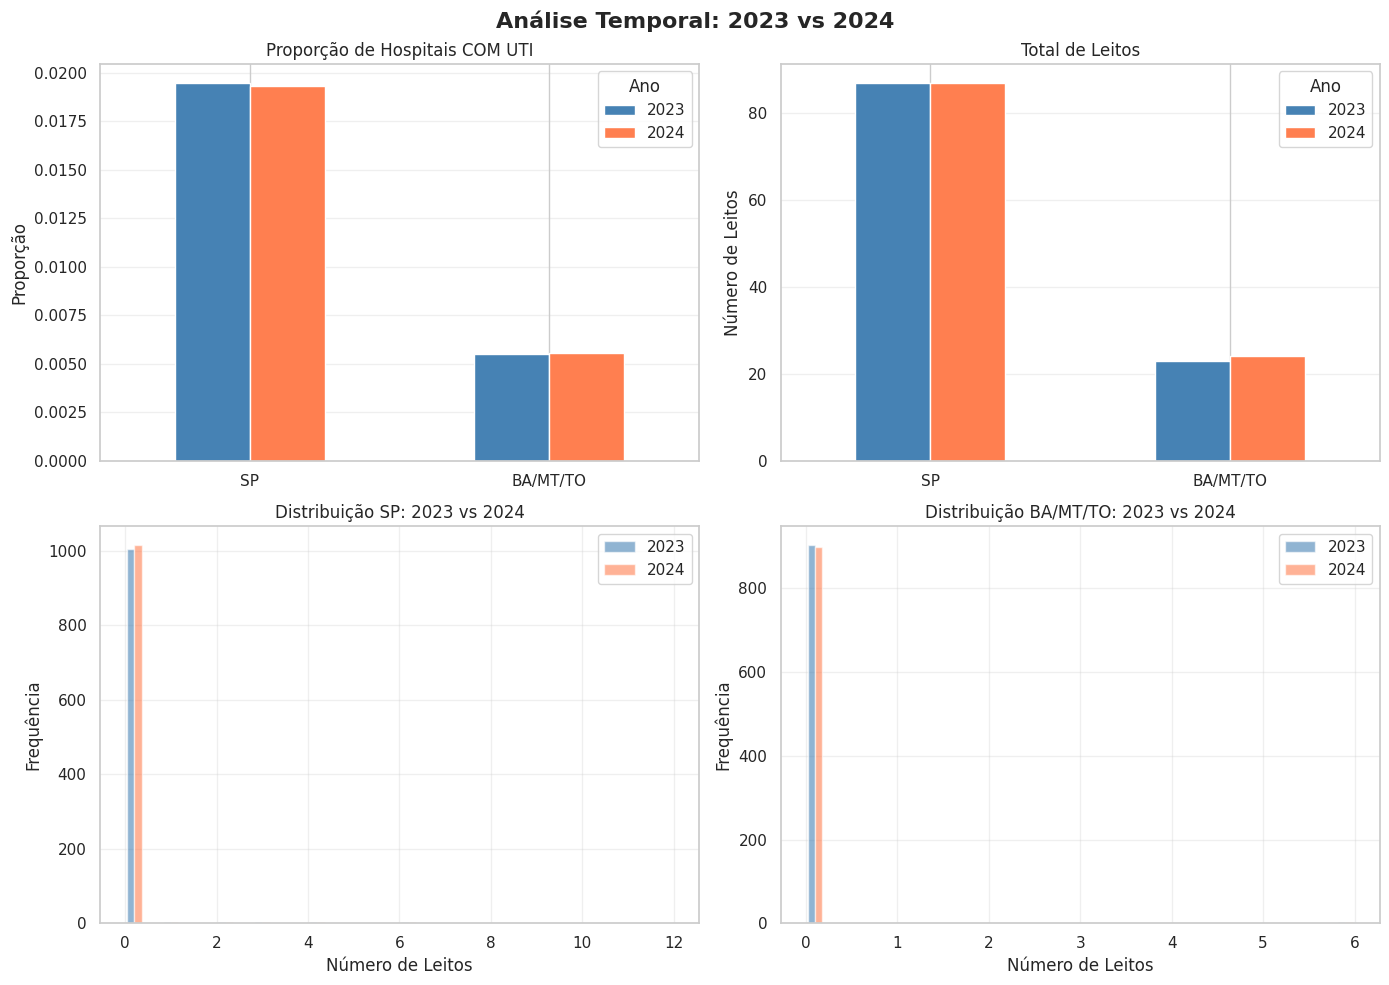

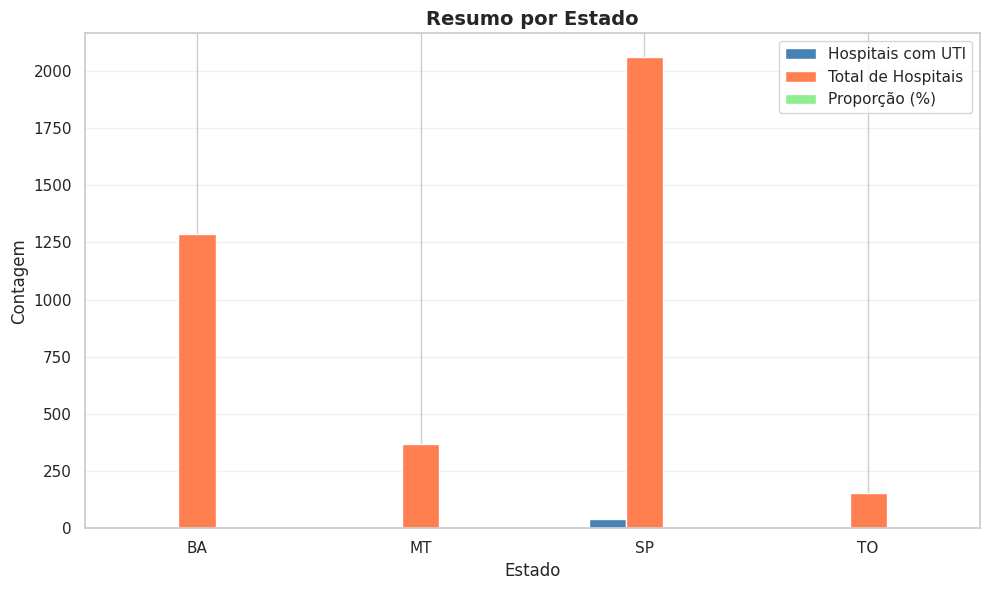

In [70]:

#@title **Análise visual dos resultados** { vertical-output: true, form-width: "60%" }

# Histogramas com Densidade
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Distribuição de Leitos de UTI de Queimados', fontsize=16, fontweight='bold')

# SP - Histograma com todos
axes[0, 0].hist(sp_data, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[0, 0].axvline(sp_data.mean(), color='red', linestyle='--', linewidth=2, label=f'Média={sp_data.mean():.3f}')
axes[0, 0].axvline(sp_data.median(), color='orange', linestyle='--', linewidth=2, label=f'Mediana={sp_data.median():.1f}')
axes[0, 0].set_title(f'SP - Todos (n={len(sp_data):,})')
axes[0, 0].set_xlabel('Número de Leitos')
axes[0, 0].set_ylabel('Frequência')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# High Risk - Histograma com todos
axes[0, 1].hist(hr_data, bins=50, alpha=0.7, color='coral', edgecolor='black')
axes[0, 1].axvline(hr_data.mean(), color='red', linestyle='--', linewidth=2, label=f'Média={hr_data.mean():.3f}')
axes[0, 1].axvline(hr_data.median(), color='orange', linestyle='--', linewidth=2, label=f'Mediana={hr_data.median():.1f}')
axes[0, 1].set_title(f'BA/MT/TO - Todos (n={len(hr_data):,})')
axes[0, 1].set_xlabel('Número de Leitos')
axes[0, 1].set_ylabel('Frequência')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# SP - Apenas COM UTI
axes[1, 0].hist(sp_with_icu, bins=20, alpha=0.7, color='steelblue', edgecolor='black')
axes[1, 0].axvline(sp_with_icu.mean(), color='red', linestyle='--', linewidth=2, label=f'Média={sp_with_icu.mean():.2f}')
axes[1, 0].set_title(f'SP - Apenas COM UTI (n={len(sp_with_icu):,})')
axes[1, 0].set_xlabel('Número de Leitos')
axes[1, 0].set_ylabel('Frequência')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# High Risk - Apenas COM UTI
axes[1, 1].hist(hr_with_icu, bins=20, alpha=0.7, color='coral', edgecolor='black')
axes[1, 1].axvline(hr_with_icu.mean(), color='red', linestyle='--', linewidth=2, label=f'Média={hr_with_icu.mean():.2f}')
axes[1, 1].set_title(f'BA/MT/TO - Apenas COM UTI (n={len(hr_with_icu):,})')
axes[1, 1].set_xlabel('Número de Leitos')
axes[1, 1].set_ylabel('Frequência')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Box Plots Comparativos
fig, axes = plt.subplots(1, 3, figsize=(16, 6))
fig.suptitle('Box Plots: Distribuição de Leitos', fontsize=16, fontweight='bold')

# Todos os dados
bp1 = axes[0].boxplot([sp_data, hr_data], tick_labels=['SP', 'BA/MT/TO'], patch_artist=True,
                       medianprops=dict(color='red', linewidth=2),
                       boxprops=dict(facecolor='lightblue', alpha=0.7))
axes[0].set_title('Todos os Hospitais')
axes[0].set_ylabel('Número de Leitos')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim(-0.5, max(sp_data.max(), hr_data.max()) + 1)

# Apenas hospitais COM UTI
bp2 = axes[1].boxplot([sp_with_icu, hr_with_icu], tick_labels=['SP', 'BA/MT/TO'], patch_artist=True,
                       medianprops=dict(color='red', linewidth=2),
                       boxprops=dict(facecolor='lightgreen', alpha=0.7))
axes[1].set_title('Apenas Hospitais COM UTI')
axes[1].set_ylabel('Número de Leitos')
axes[1].grid(True, alpha=0.3, axis='y')

# Capital vs Interior
cap_data = df_unique[df_unique['IS_CAPITAL']==True]['UTI_QUEIMADO_EXIST']
int_data = df_unique[df_unique['IS_CAPITAL']==False]['UTI_QUEIMADO_EXIST']
bp3 = axes[2].boxplot([cap_data, int_data], tick_labels=['Capital', 'Interior'], patch_artist=True,
                       medianprops=dict(color='red', linewidth=2),
                       boxprops=dict(facecolor='lightyellow', alpha=0.7))
axes[2].set_title('Capital vs Interior')
axes[2].set_ylabel('Número de Leitos')
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Análise Temporal
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Análise Temporal: 2023 vs 2024', fontsize=16, fontweight='bold')

# Proporção de hospitais COM UTI por ano
prop_temporal = pd.DataFrame({
    '2023': [df_2023_unique[df_2023_unique['GROUP']=='SP']['HAS_BURN_ICU'].mean(),
             df_2023_unique[df_2023_unique['GROUP']=='High_Risk']['HAS_BURN_ICU'].mean()],
    '2024': [df_2024_unique[df_2024_unique['GROUP']=='SP']['HAS_BURN_ICU'].mean(),
             df_2024_unique[df_2024_unique['GROUP']=='High_Risk']['HAS_BURN_ICU'].mean()]
}, index=['SP', 'BA/MT/TO'])

prop_temporal.plot(kind='bar', ax=axes[0, 0], color=['steelblue', 'coral'])
axes[0, 0].set_title('Proporção de Hospitais COM UTI')
axes[0, 0].set_ylabel('Proporção')
axes[0, 0].set_xlabel('')
axes[0, 0].legend(title='Ano')
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=0)

# Número total de leitos por ano
leitos_temporal = pd.DataFrame({
    '2023': [df_2023_unique[df_2023_unique['GROUP']=='SP']['UTI_QUEIMADO_EXIST'].sum(),
             df_2023_unique[df_2023_unique['GROUP']=='High_Risk']['UTI_QUEIMADO_EXIST'].sum()],
    '2024': [df_2024_unique[df_2024_unique['GROUP']=='SP']['UTI_QUEIMADO_EXIST'].sum(),
             df_2024_unique[df_2024_unique['GROUP']=='High_Risk']['UTI_QUEIMADO_EXIST'].sum()]
}, index=['SP', 'BA/MT/TO'])

leitos_temporal.plot(kind='bar', ax=axes[0, 1], color=['steelblue', 'coral'])
axes[0, 1].set_title('Total de Leitos')
axes[0, 1].set_ylabel('Número de Leitos')
axes[0, 1].set_xlabel('')
axes[0, 1].legend(title='Ano')
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=0)

# Distribuição SP: 2023 vs 2024
sp_2023 = df_2023_unique[df_2023_unique['GROUP']=='SP']['UTI_QUEIMADO_EXIST']
sp_2024 = df_2024_unique[df_2024_unique['GROUP']=='SP']['UTI_QUEIMADO_EXIST']
axes[1, 0].hist([sp_2023, sp_2024], bins=30, alpha=0.6, label=['2023', '2024'], color=['steelblue', 'coral'])
axes[1, 0].set_title('Distribuição SP: 2023 vs 2024')
axes[1, 0].set_xlabel('Número de Leitos')
axes[1, 0].set_ylabel('Frequência')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Distribuição HR: 2023 vs 2024
hr_2023 = df_2023_unique[df_2023_unique['GROUP']=='High_Risk']['UTI_QUEIMADO_EXIST']
hr_2024 = df_2024_unique[df_2024_unique['GROUP']=='High_Risk']['UTI_QUEIMADO_EXIST']
axes[1, 1].hist([hr_2023, hr_2024], bins=30, alpha=0.6, label=['2023', '2024'], color=['steelblue', 'coral'])
axes[1, 1].set_title('Distribuição BA/MT/TO: 2023 vs 2024')
axes[1, 1].set_xlabel('Número de Leitos')
axes[1, 1].set_ylabel('Frequência')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Distribuição por Estado
fig, ax = plt.subplots(figsize=(10, 6))
state_summary = df_unique.groupby('UF').agg({
    'HAS_BURN_ICU': 'sum',
    'CNES': 'count'
}).rename(columns={'CNES': 'Total_Hospitais'})
state_summary['Proporção (%)'] = (state_summary['HAS_BURN_ICU'] / state_summary['Total_Hospitais'] * 100)

state_summary.plot(kind='bar', ax=ax, color=['steelblue', 'coral', 'lightgreen'])
ax.set_title('Resumo por Estado', fontsize=14, fontweight='bold')
ax.set_xlabel('Estado')
ax.set_ylabel('Contagem')
ax.legend(['Hospitais com UTI', 'Total de Hospitais', 'Proporção (%)'])
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [74]:
#@title **Testes estatítisticos** { vertical-output: true, form-width: "60%" }

# ---  TESTES ESTATÍSTICOS PRINCIPAIS ---

# Mann-Whitney U Test
print("Dada a natureza dos dados, foi escolhido o teste de mann-whitney para análise dos dados")
print("\n--- Teste de Mann-Whitney (Distribuição de Leitos) ---")
u_stat, p_mann = stats.mannwhitneyu(sp_data, hr_data, alternative='two-sided')
print(f"U-statistic: {u_stat:,.0f}")
print(f"P-valor: {p_mann:.6f}")
print(f"Conclusão: 'Diferença SIGNIFICATIVA' (α=0.05)")

# Qui-Quadrado
print("\n--- Teste Qui-Quadrado (Presença de UTI) ---")
contingency = pd.crosstab(df_unique['GROUP'], df_unique['HAS_BURN_ICU'])
chi2, p_chi2, dof, expected = stats.chi2_contingency(contingency)
print(f"\nTabela de Contingência Observada:")
print(contingency)
print(f"\nTabela de Contingência Esperada:")
print(pd.DataFrame(expected, columns=contingency.columns, index=contingency.index).round(2))
print(f"\nχ² = {chi2:.4f}")
# O que é grau de liberdade?
# Graus de liberdade (GDL) são o número de valores em um cálculo que são livres
# para variar e que determinam a quantidade de informações independentes
# em um conjunto de dados
print(f"Graus de liberdade = {dof}")
print(f"P-valor: {p_chi2:.6f}")
print(f"Conclusão: Associação SIGNIFICATIVA entre região e presença de UTI")

# A razão de chances ou razão de possibilidades é definida como a razão entre a chance de um evento ocorrer em um grupo e a chance de ocorrer em outro grupo
# Odds Ratio
a = contingency.loc['SP', 1]
b = contingency.loc['SP', 0]
c = contingency.loc['High_Risk', 1]
d = contingency.loc['High_Risk', 0]
odds_ratio = (a * d) / (b * c)

# Intervalo de Confiança do OR (Método de Woolf)
se_log_or = np.sqrt(1/a + 1/b + 1/c + 1/d)
ci_lower = np.exp(np.log(odds_ratio) - 1.96 * se_log_or)
ci_upper = np.exp(np.log(odds_ratio) + 1.96 * se_log_or)

print(f"\n--- Odds Ratio ---")
print(f"OR = {odds_ratio:.2f} (IC 95%: {ci_lower:.2f} - {ci_upper:.2f})")
print(f"Interpretação: Hospitais em SP têm {odds_ratio:.2f}x mais chances de ter UTI de Queimados")

Dada a natureza dos dados, foi escolhido o teste de mann-whitney para análise dos dados

--- Teste de Mann-Whitney (Distribuição de Leitos) ---
U-statistic: 1,892,106
P-valor: 0.000138
Conclusão: 'Diferença SIGNIFICATIVA' (α=0.05)

--- Teste Qui-Quadrado (Presença de UTI) ---

Tabela de Contingência Observada:
HAS_BURN_ICU     0   1
GROUP                 
High_Risk     1801  10
SP            2021  40

Tabela de Contingência Esperada:
HAS_BURN_ICU        0      1
GROUP                       
High_Risk     1787.61  23.39
SP            2034.39  26.61

χ² = 13.5137
Graus de liberdade = 1
P-valor: 0.000237
Conclusão: Associação SIGNIFICATIVA entre região e presença de UTI

--- Odds Ratio ---
OR = 3.56 (IC 95%: 1.78 - 7.15)
Interpretação: Hospitais em SP têm 3.56x mais chances de ter UTI de Queimados


In [75]:
# --- Análise final  ---
print("\n" + "="*80)

print("\n1. NORMALIDADE DOS DADOS:")
print(f"   - Dados seguem distribuição normal? NÃO (p < 0.001)")
print(f"   - Assimetria extrema (CV > 800%)")

print("\n2. COMPARAÇÃO ENTRE GRUPOS:")
print(f"   - SP: {stats_comprehensive.loc['SP', 'N com UTI']:.0f} hospitais com UTI ({stats_comprehensive.loc['SP', 'Proporção (%)']:.2f}%)")
print(f"   - BA/MT/TO: {stats_comprehensive.loc['High_Risk', 'N com UTI']:.0f} hospitais com UTI ({stats_comprehensive.loc['High_Risk', 'Proporção (%)']:.2f}%)")
print(f"   - Odds Ratio: {odds_ratio:.2f} (SP vs BA/MT/TO)")
print(f"   - Diferença estatisticamente significativa (p < 0.001)")

print("\n3. ANÁLISE TEMPORAL:")
print(f"   - Mudança de 2023 para 2024: Não significativa (p={p_temp:.4f})")



1. NORMALIDADE DOS DADOS:
   - Dados seguem distribuição normal? NÃO (p < 0.001)
   - Assimetria extrema (CV > 800%)

2. COMPARAÇÃO ENTRE GRUPOS:
   - SP: 40 hospitais com UTI (1.94%)
   - BA/MT/TO: 10 hospitais com UTI (0.55%)
   - Odds Ratio: 3.56 (SP vs BA/MT/TO)
   - Diferença estatisticamente significativa (p < 0.001)

3. ANÁLISE TEMPORAL:
   - Mudança de 2023 para 2024: Não significativa (p=1.0000)
